# Logistic Regression

You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import inspect
from utils import loadDataset

%matplotlib inline

In [2]:
def retrieve_name(var):
  callers_local_vars = inspect.currentframe().f_back.f_locals.items()
  return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [3]:
def array_info(array, array_name="Noname"):
  print("*" * 60)
  print("<<<array_info func:{0}>>>".format(array_name))
  print("-" * 60)
  #print("array=", array)
  print("type=", type(array))
  print("ndim:", array.ndim)
  print("shape:", array.shape)
  print("dtype:", array.dtype)
  print("size:", array.size)  #item 개수
  print("itemsize:", array.itemsize) #item size
  print("nbytes:", array.nbytes)  # size * itemsize
  print("strides:", array.strides) # array내의 각 item에서 다음 item간의 바이트 간격?
  print("*" * 60)

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
> - a training set of MTrain images labeled as cat (y=1) or non-cat (y=0)
> - a test set of MTest images labeled as cat or non-cat
> - each image is of shape (numPixel, numPixel, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = numPixel) and (width = numPixel).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [4]:
# Loading the data (cat/non-cat)
trainSetXorig, trainSetY, testSetXorig, testSetY, classes = loadDataset()
#array_info(trainSetXorig, retrieve_name(trainSetXorig))
array_info(classes, retrieve_name(classes))
#array_info(trainSetY, retrieve_name(trainSetY))

# 이미지파일의 모든 픽셀들은 해당 데이터의 피쳐들이다.

************************************************************
<<<array_info func:['classes']>>>
------------------------------------------------------------
type= <class 'numpy.ndarray'>
ndim: 1
shape: (2,)
dtype: |S7
size: 2
itemsize: 7
nbytes: 14
strides: (7,)
************************************************************


We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with trainSetX and testSetX (the labels trainSetY and testSetY don't need any preprocessing).

Each line of your trainSetXorig and testSetXorig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

<class 'numpy.ndarray'>
<class 'numpy.int64'>
[1]
1
()
y = [1], it's a 'cat' picture.


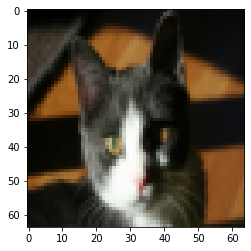

In [5]:
# Example of a picture
index = 19
plt.imshow(trainSetXorig[index])
x = trainSetY[:, index]
print(type(x))
y = trainSetY[0][index]
print(type(y))
print(x)
print(y)
z = np.squeeze(trainSetY[:, index])
print(z.shape)
print ("y = " + str(trainSetY[:, index]) + ", it's a '" + classes[np.squeeze(trainSetY[:, index])].decode("utf-8") +  "' picture.")

### Exercise1
Find the values for:
> - Mtrain (number of training examples)
> - Mtest (number of test examples)
> - numPixel (= height = width of a training image)

Remember that `trainSetXorig` is a numpy-array of shape (Mtrain, numPixel, numPixel, 3). For instance, you can access `Mtrain` by writing `trainSetXorig.shape[0]`.

In [6]:
### START CODE HERE ### (≈ 3 lines of code)
Mtrain = trainSetXorig.shape[0]
Mtest = testSetXorig.shape[0]
numPixel = trainSetXorig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(Mtrain))
print ("Number of testing examples: m_test = " + str(Mtest))
print ("Height/Width of each image: num_px = " + str(numPixel))
print ("Each image is of size: (" + str(numPixel) + ", " + str(numPixel) + ", 3)")
print ("trainSetXorig shape: " + str(trainSetXorig.shape))
print ("trainSetY shape: " + str(trainSetY.shape))
print ("testSetXorig shape: " + str(testSetXorig.shape))
print ("testSetY shape: " + str(testSetY.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
trainSetXorig shape: (209, 64, 64, 3)
trainSetY shape: (1, 209)
testSetXorig shape: (50, 64, 64, 3)
testSetY shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**Mrain**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**Mtest**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**numPixel**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (numPixel, numPixel, 3) in a numpy-array of shape (numPixel $*$ numPixel $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be Mtrain (respectively Mtest) columns.

### Exercise 2
Reshape the training and test data sets so that images of size (numPixel, numPixel, 3) are flattened into single vectors of shape (numPixel $*$ numPixel $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix Xflatten of shape (b$*$c$*$d, a) is to use: 
```python
Xflatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [7]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
trainSetXFlatten = trainSetXorig.reshape(trainSetXorig.shape[0], -1).T
testSetXFlatten = testSetXorig.reshape(testSetXorig.shape[0], -1).T
### END CODE HERE ###

print ("trainSetXFlatten shape: " + str(trainSetXFlatten.shape))
print ("trainSetY shape: " + str(trainSetY.shape))
print ("testSetXFlatten shape: " + str(testSetXFlatten.shape))
print ("testSetY shape: " + str(testSetY.shape))
print ("sanity check after reshaping: " + str(trainSetXFlatten[0:5,0]))

trainSetXFlatten shape: (12288, 209)
trainSetY shape: (1, 209)
testSetXFlatten shape: (12288, 50)
testSetY shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**trainSetXFlatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**trainSetY shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**testSetXFlatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**testSetY shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [8]:
trainSetX = trainSetXFlatten/255.
testSetX = testSetXFlatten/255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (Mtrain, Mtest, numPixel, ...)
- Reshape the datasets such that each example is now a vector of size (numPixel \* numPixel \* 3, 1)
- "Standardize" the data

## 3 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.



### 3.1 - Helper functions



####Exercise 3
Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [9]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [10]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 3.2 - Initializing parameters



####Exercise 4
Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [95]:
# GRADED FUNCTION: initializeParameterSetZeros

def initializeParameterSetZeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0
    ### END CODE HERE ###    
    
    return w, b

In [12]:
dim = 2 # dimension of feature vector
w, b = initializeParameterSetZeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 2


### 3.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.



#### Exercise 5
Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [96]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1) # 
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples) # 
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    # compute activation
    A = sigmoid(np.dot(w.T,X)+b)
    # compute cost by using np.dot to perform multiplication.
    # And don't use loops for the sum.
    cost = -(1/m) * (np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T))
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [66]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 3.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.



####Exercise 6 - optimize
Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [15]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, numIterations, learningRate, printCost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    #w = copy.deepcopy(w)
    #b = copy.deepcopy(b)

    costs = []
    
    for i in range(numIterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w,b,X,Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learningRate*dw
        b = b - learningRate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if printCost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [16]:
params, grads, costs = optimize(w, b, X, Y, numIterations= 100, learningRate = 0.009, printCost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Expected Output**: 

|||
|--|--|
|w|[[ 0.19033591] [ 0.12259159]]|
|b|1.92535983008|
|dw|[[0.67752042] [1.41625495]]|
|db|0.219194504541|

#### Exercise 7 - predict
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [17]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    YPrediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1] # X의 column
    YPrediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot((w.T),X)+b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
      # Convert probabilities A[0,i] to actual predictions p[0,i]
      ### START CODE HERE ### (≈ 4 lines of code)
      if A[0, i] <= 0.5 :
        YPrediction[0][i] = 0
      else:
        YPrediction[0][i] = 1        
      ### END CODE HERE ###
    
    assert(YPrediction.shape == (1, m))
    
    return YPrediction

In [18]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**

You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 4 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.



### Exercise 8 - model
Implement the model function. Use the following notation:
* YPredictionTest for your predictions on the test set
* YPredictionTrain for your predictions on the train set
* w, costs, grads for the outputs of optimize()

In [19]:
print(trainSetX.shape)

(12288, 209)


In [97]:
# GRADED FUNCTION: model

def model(XTrain, YTrain, XTest, YTest, numIterations = 2000, learningRate = 0.5, printCost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    XTrain -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    YTrain -- training labels represented by a numpy array (vector) of shape (1, m_train)
    XTest -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    YTest -- test labels represented by a numpy array (vector) of shape (1, m_test)
    numIterations -- hyperparameter representing the number of iterations to optimize the parameters
    learningRate -- hyperparameter representing the learning rate used in the update rule of optimize()
    printCost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initializeParameterSetZeros(XTrain.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w,b,XTrain,YTrain,numIterations,learningRate,printCost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    YPredictionTest = predict(w,b,XTest)
    YPredictionTrain = predict(w,b,XTrain)

    ### END CODE HERE ###

    # Print train/test Errors
    if printCost:
      print("train accuracy: {} %".format(100 - np.mean(np.abs(YPredictionTrain - YTrain)) * 100))
      print("test accuracy: {} %".format(100 - np.mean(np.abs(YPredictionTest - YTest)) * 100))

    
    d = {"costs": costs,
         "YPredictionTest": YPredictionTest, 
         "YPredictionTrain" : YPredictionTrain, 
         "w" : w, 
         "b" : b,
         "learningRate" : learningRate,
         "numIterations": numIterations}
    
    return d

Run the following cell to train your model.

In [98]:
logisticRegressionModel = model(trainSetX, trainSetY, testSetX, testSetY, numIterations = 2000, learningRate = 0.005, printCost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

|||
|--|--|
|Cost after iteration 0|0.693147|
|Train Accuracy|99.04306220095694|
|Test Accuracy|70.0 %|

**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

y = 1, you predicted that it is a "cat" picture.


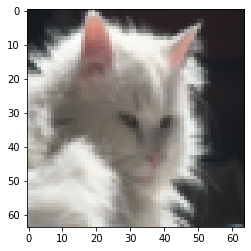

In [107]:
# Example of a picture that was wrongly classified.
index = 8
plt.imshow(testSetX[:,index].reshape((numPixel, numPixel, 3)))
print ("y = " + str(testSetY[0,index]) + ", you predicted that it is a \"" + classes[int(logisticRegressionModel['YPredictionTest'][0,index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

<class 'list'>
************************************************************
<<<array_info func:<function retrieve_name at 0x7f5571b78ef0>>>>
------------------------------------------------------------
type= <class 'numpy.ndarray'>
ndim: 1
shape: (20,)
dtype: float64
size: 20
itemsize: 8
nbytes: 160
strides: (8,)
************************************************************


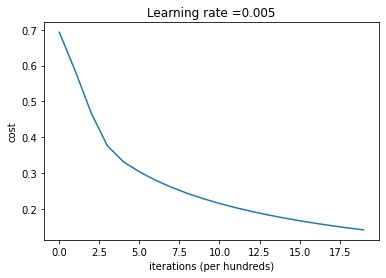

In [108]:
# Plot learning curve (with costs)
print(type(logisticRegressionModel['costs']))
costs = np.squeeze(logisticRegressionModel['costs'])
array_info(costs, retrieve_name)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logisticRegressionModel["learningRate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 